# RQ2 additional results

But software performances are influenced by the configuration options e.g. the energy consumption. 
An option is called influential for a performance when its values have a strong effect on this performance. 
For example, developers might wonder whether the option they add to a configurable software has an influence on its performance.
However, is an option identified as influential for some inputs still influential for other inputs?
If not, it would become both tedious and time-consuming to find influential options on a per-input basis. 
Besides, it is unclear if activating an option is always worth it in terms of performance; an option could improve the overall performance but reduce it for few inputs. 
If so, users may wonder which options to enable to improve software performances based on their input data. 

In order to understand how a performance model can change based on a given input, we next study how input data interact with configuration options. 

## RQ2 - Do configuration option’s effects change with input data?


To assess the relative importances and effects of options, we use two well-known statistical methods. 


**Random Forest Importances.** The tree structure provides insights about the most essential options for prediction as a tree splits first options that provide the highest information gain. 
We use random forests (a vote between multiple decision trees):
we can derive, from the forests trained on the inputs, estimates of the options importance. 
The computation of option importance is realized through the observation of the eﬀect on random forest accuracy of randomly shuffling each predictor variable.
For a random forest, we consider that an option is influential if its option importance (i.e. median on all inputs) is greater than $\frac{1}{n_{opt}}$, where $n_{opt}$ is the number of options considered in the dataset. 
This threshold represents the theoretic importance of options for a software having equally important options (inspired by the Kaiser rule). 


**Linear Regression Coefficients.** The coefficients of an Ordinary Least Square (OLS) regression weight the effect of configuration options. 
These coefficients can be positive (resp. negative) if a bigger (resp. lower) option value results in a bigger performance. 
Ideally, the sign of the coefficients of a given option should remain the same for all inputs: it would suggest that the effect of an option onto performance is stableWe also provide details about coefficients related to the interactions of options (i.e. feature interactions).


#### First, we import some libraries

In [3]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
# mean absolute percentage error
from sklearn.metrics import mean_absolute_percentage_error


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ2 code

## Compute importances

In [28]:
def compute_importances(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of importances
    listImportances = []
    listMAPE = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in features:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=20)
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        listMAPE.append(mean_absolute_percentage_error(clf.predict(X), y))
        
        # we add feature importances to the list
        listImportances.append(clf.feature_importances_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listImportances)):
        res['video_'+str(id_input)] = np.round(cs*listImportances[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    print("RF")
    print(np.median(listMAPE))
    
    # return it 
    return res

## Compute effects

In [35]:
def compute_coefs(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of coefficients
    listCoefs = []
    
    listMAPE = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "NaN", value = '0')
        df = df.replace(to_replace = "None", value = '0')

        # standardization
        for col in to_keep:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        # for each video, we train a model
        indexes = np.array([k for k in range(len(df[dim])) 
                            if df[dim][k] != float("inf") and not np.isnan(df[dim][k])],int)
        lr = LinearRegression()
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = [float(k) for k in df[dim]]
        #print(y)
        # we train the model on all the data (not train-test since we don't use the model)
        lr.fit(X, y)
        
        listMAPE.append(mean_absolute_percentage_error(lr.predict(X), y))
        
        # we add feature importances to the list
        listCoefs.append(lr.coef_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listCoefs)):
        res['video_'+str(id_input)] = np.round(cs*listCoefs[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
        
    print("LR")
    print(np.median(listMAPE))
    
    # return it 
    return res

## Show the boxplot of effects and importances

In [36]:
def boxplot_imp(ns, dim, xlim = None, xname='Importances'):
    ### in: 
    #### ns the name of the system
    #### dim the name of the current performance property
    #### xlim limits if needed to focus on the important part of the chart
    #### xname the name of the abcissae and if we compute the importances or the effects
    ### out :
    #### a boxplot (saved in the system file)
    
    if xname == 'Importances':
        res = compute_importances(ns, dim)
    else:
        res = compute_coefs(ns, dim)
    
    # sort by names
    listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
               for col in res.columns]
    listImp.sort(key=lambda tup: tup[2], reverse=True)

    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if xname == 'Importances':
        plt.savefig("../../../results/systems/"+ns+"/"+"boxplot_imp_"+dim+".png")
    else:
        plt.savefig("../../../results/systems/"+ns+"/"+"boxplot_effect_"+dim+".png")
    plt.show()

# RQ2 results for each system

### GCC

#### compilation time

RF
0.0284828822245891


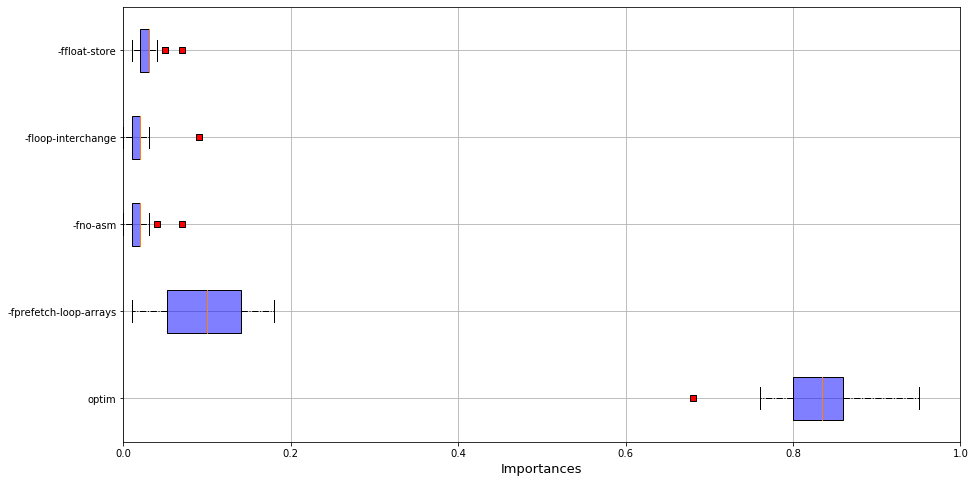

LR
9.969166110915317


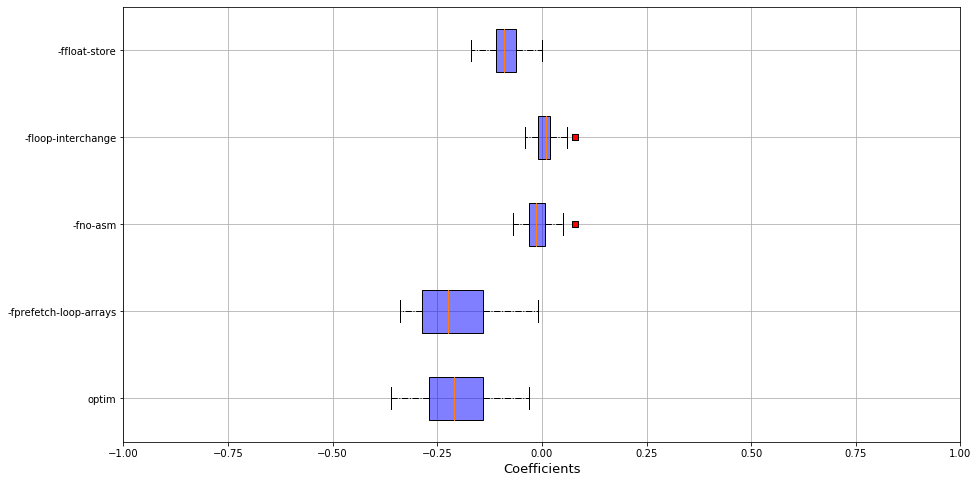

In [37]:
boxplot_imp("gcc", "ctime", xlim =[0,1], xname='Importances')
boxplot_imp("gcc", "ctime", xlim =[-1,1], xname='Coefficients')

Overall, for the compilation time of gcc, there is one influential options, namely `optim` i.e., the flag -Og -O1 -O2 -O3 -Ofast

Apart from one single value, this option is always negatively related to the time; without much surprise, activating -Ofast decreases the compile time of the program.

#### execution time

RF
0.007424360342158147


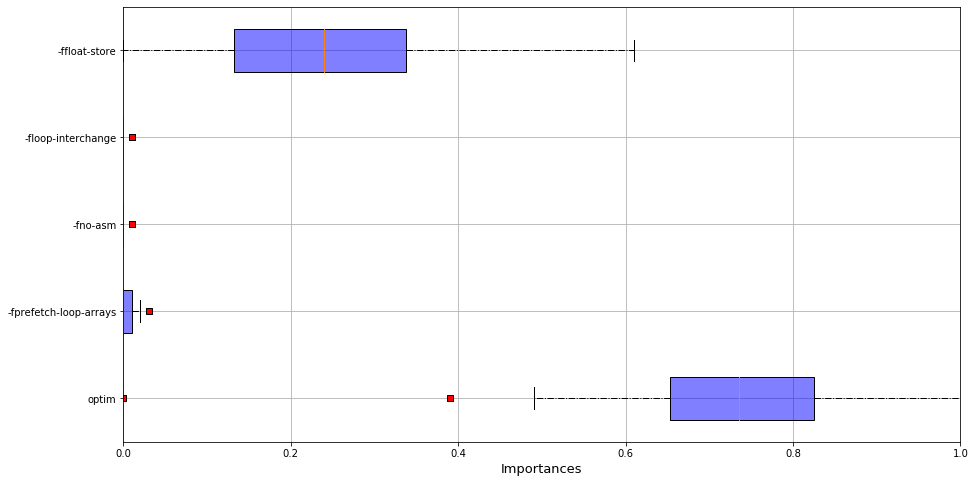

LR
2.613727634602696


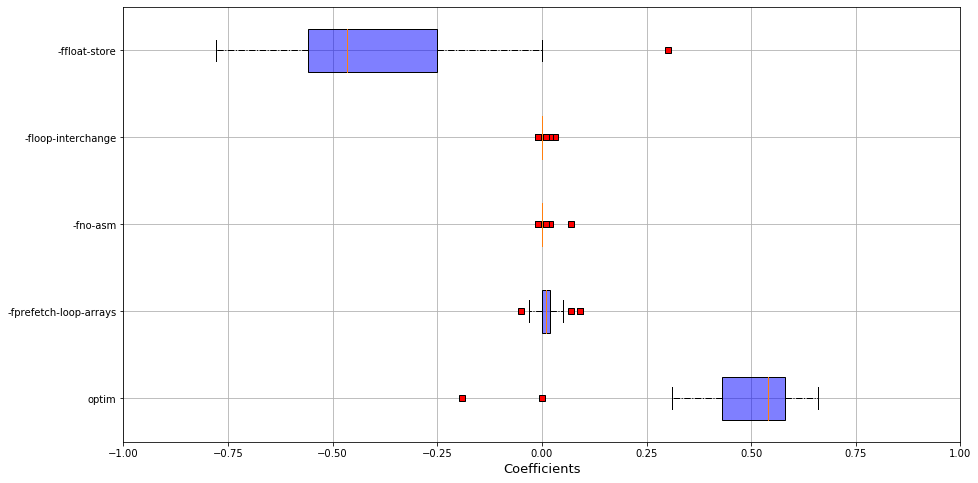

In [38]:
boxplot_imp("gcc", "exec", xlim =[0,1], xname='Importances')
boxplot_imp("gcc", "exec", xlim =[-1,1], xname='Coefficients')

Overall, for the execution time of gcc, there is two influential options, namely `optim` i.e., the flag -Og -O1 -O2 -O3 -Ofast and `-ffloat-store`

#### size

RF
0.001633003556909114


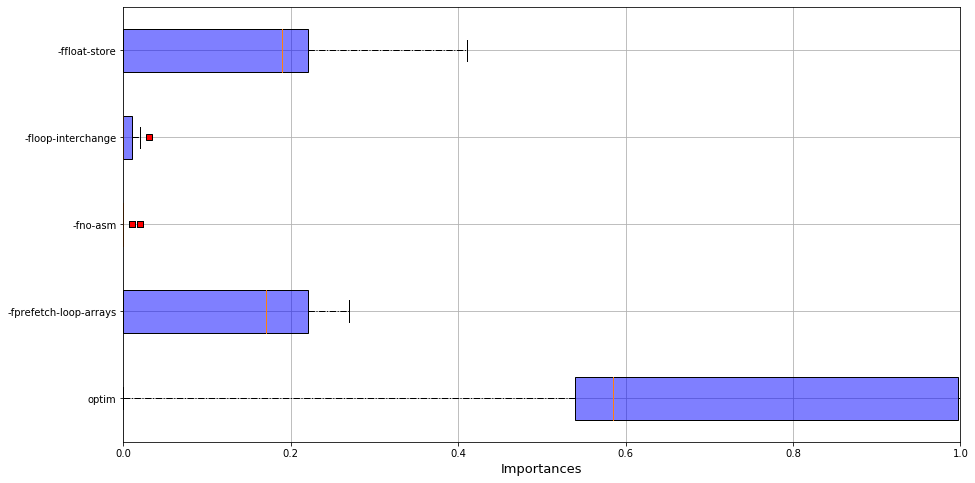

LR
67539777342676.92


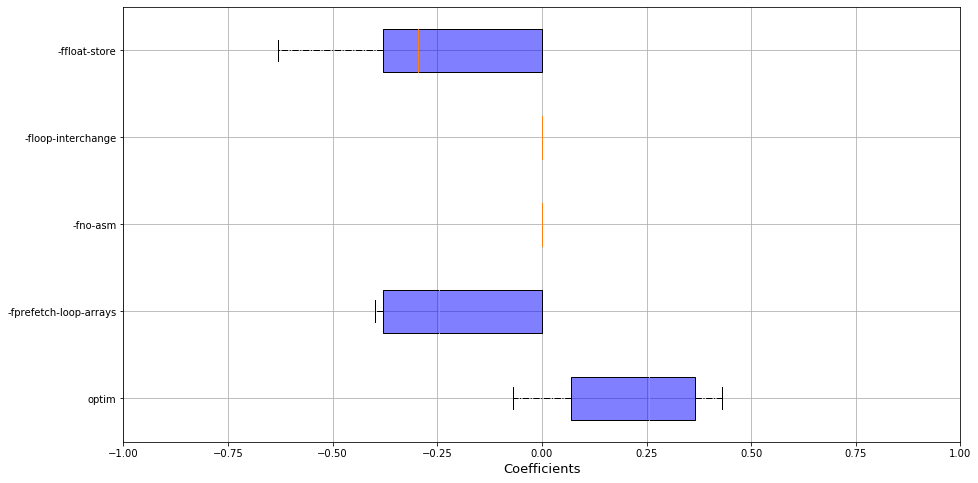

In [39]:
boxplot_imp("gcc", "size", xlim =[0,1], xname='Importances')
boxplot_imp("gcc", "size", xlim =[-1,1], xname='Coefficients')

For the binary size, it is a very interesting result; there is nothing wrong with the boxplots of the upper charts, there is only one value for each, so we are not able to see them.

As presented in the paper, this is our textbook case of a stable software system (in our experiment) w.r.t. the input sensitivity.

### Imagemagick

#### time

RF
0.013783174157989832


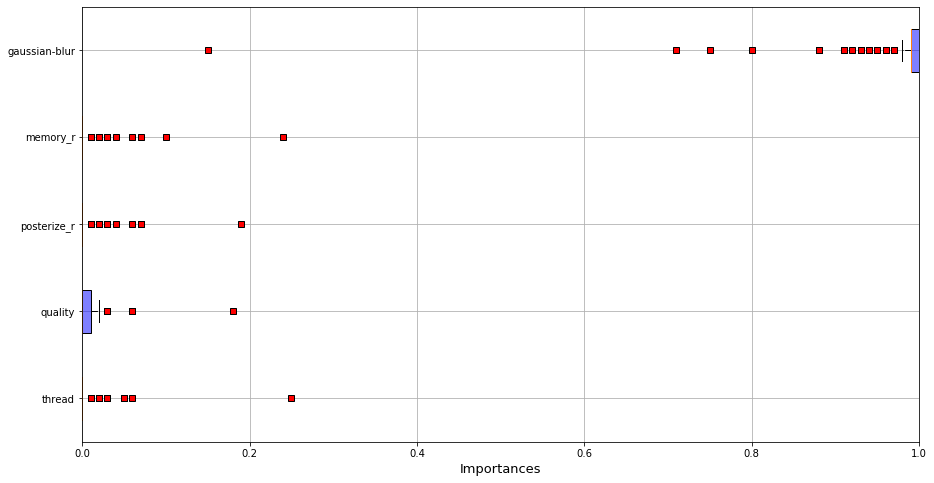

LR
1.9162130943927793


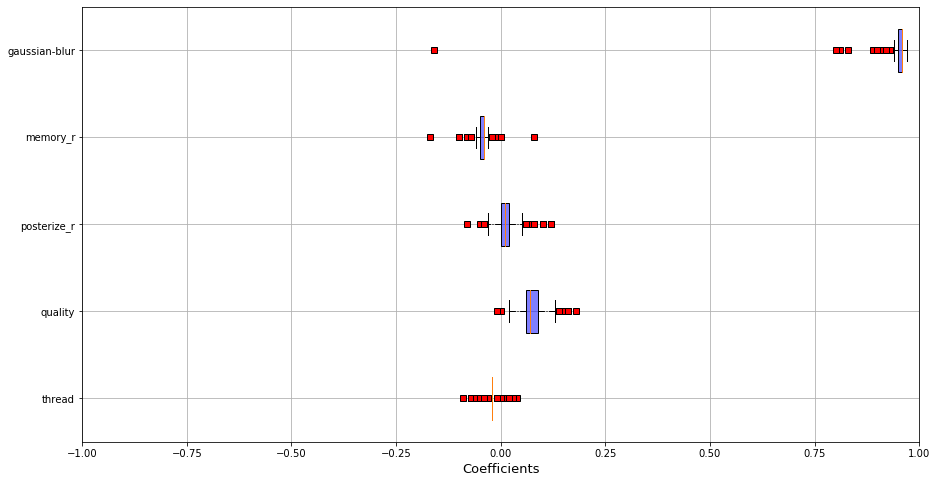

In [40]:
boxplot_imp("imagemagick", "time", xlim =[0,1], xname='Importances')
boxplot_imp("imagemagick", "time", xlim =[-1,1], xname='Coefficients')

### Lingeling

#### conflicts

RF
0.011942821910664314


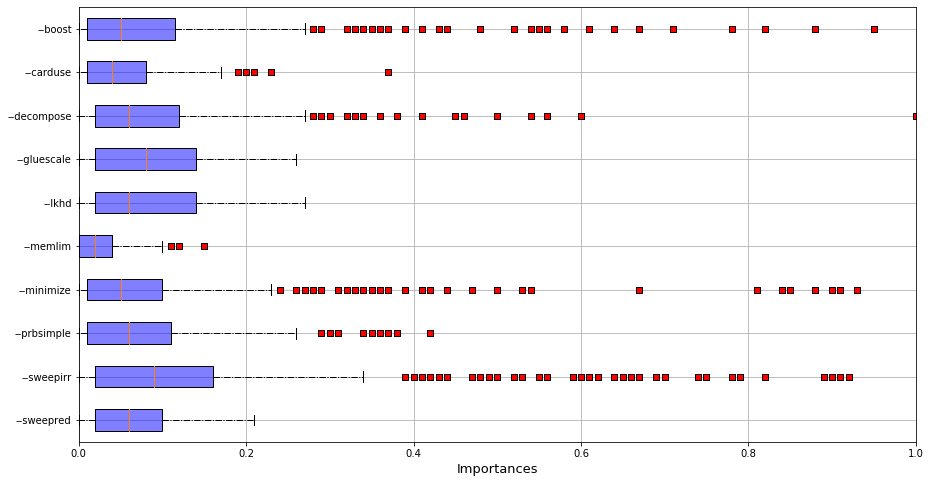

LR
3.6235055081330048


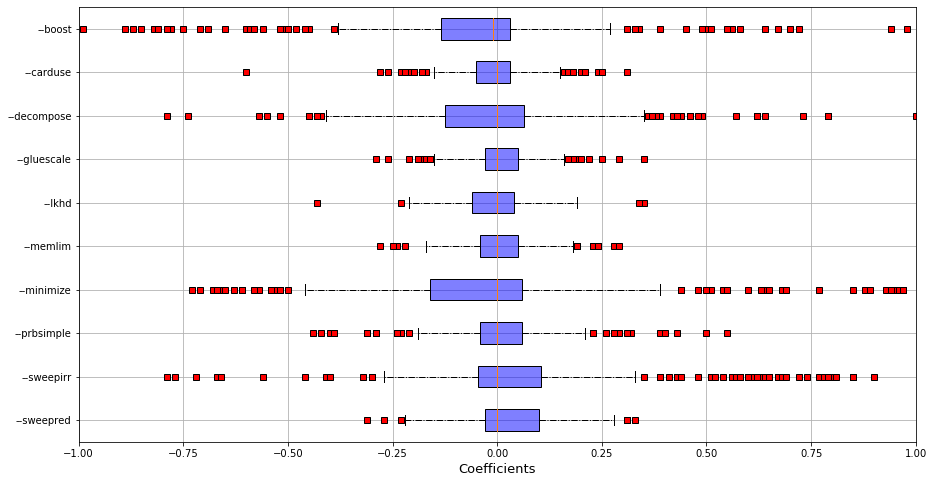

In [41]:
boxplot_imp("lingeling", "conflicts", xlim =[0,1], xname='Importances')
boxplot_imp("lingeling", "conflicts", xlim =[-1,1], xname='Coefficients')

For lingeling, to contrast with gcc, there are lots of variations depending on the SAT formula processed by the software. 

There are many corner cases, for which an option becomes suddently influential.

Most options can have positive and negative effects depending on inputs.

#### conflicts per second

RF
0.011468970941550503


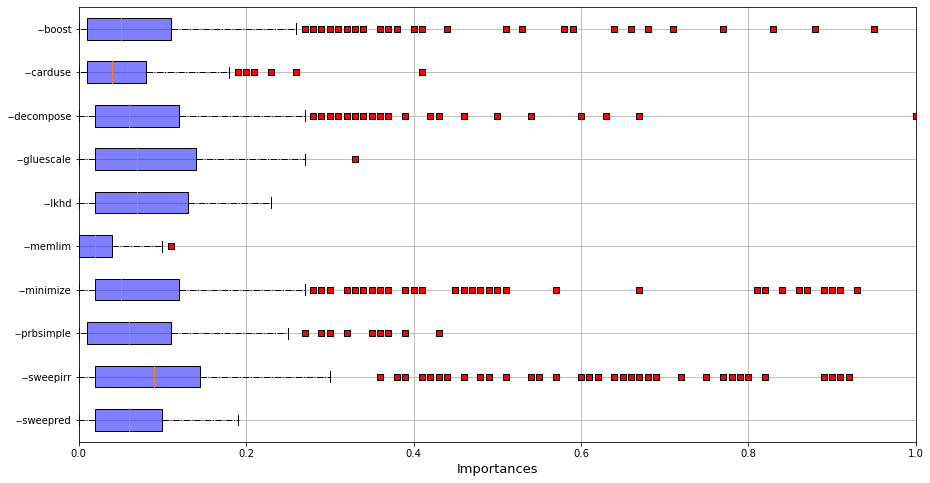

LR
3.423707494001929


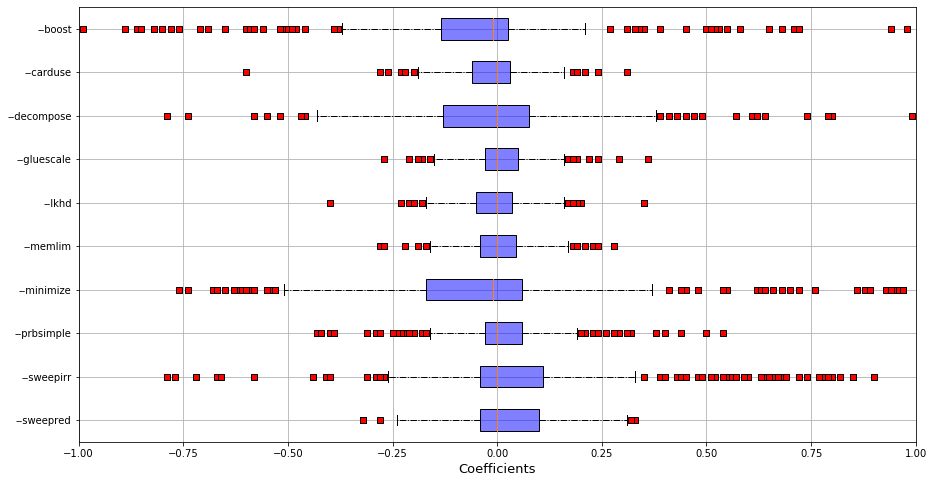

In [42]:
boxplot_imp("lingeling", "cps", xlim =[0,1], xname='Importances')
boxplot_imp("lingeling", "cps", xlim =[-1,1], xname='Coefficients')

Same conclusion as for the conflicts performance property.

#### reductions

RF
0.007666723212382927


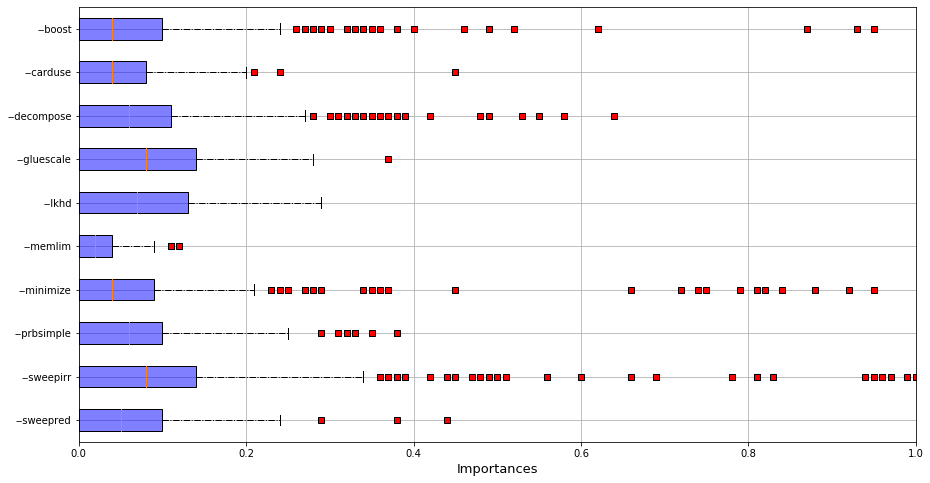

LR
3.4104545607664094


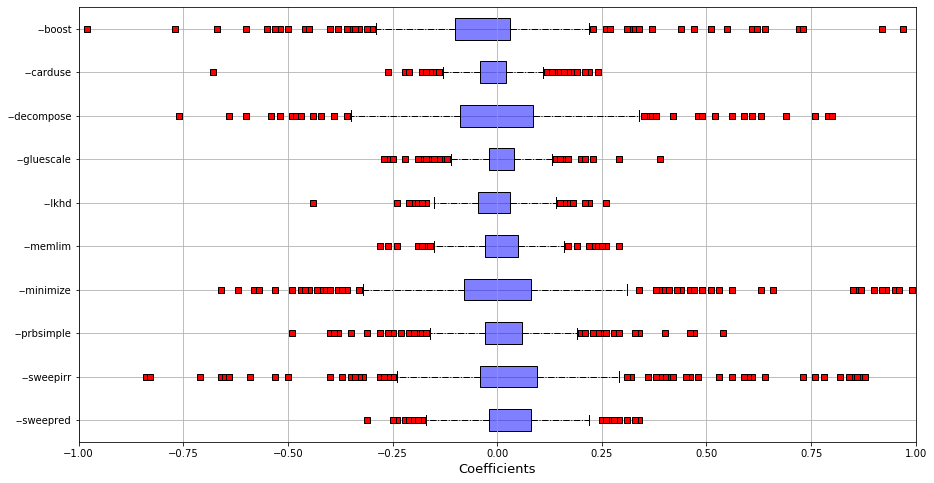

In [43]:
boxplot_imp("lingeling", "reductions", xlim =[0,1], xname='Importances')
boxplot_imp("lingeling", "reductions", xlim =[-1,1], xname='Coefficients')

Again, all the options might be influential at some point, for few inputs.

An expertise of the domain could help to understand the link between the content of these formulae and the way it is processed by the software i.e. how it interacts with configuration options. 

### NodeJS

#### number of operations per second

RF
0.010223746760413856


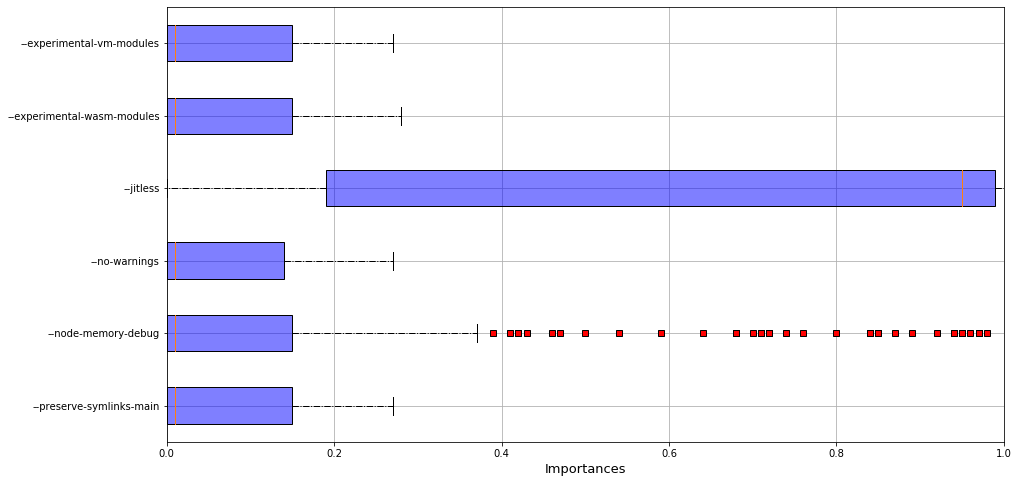

LR
0.15476514643539943


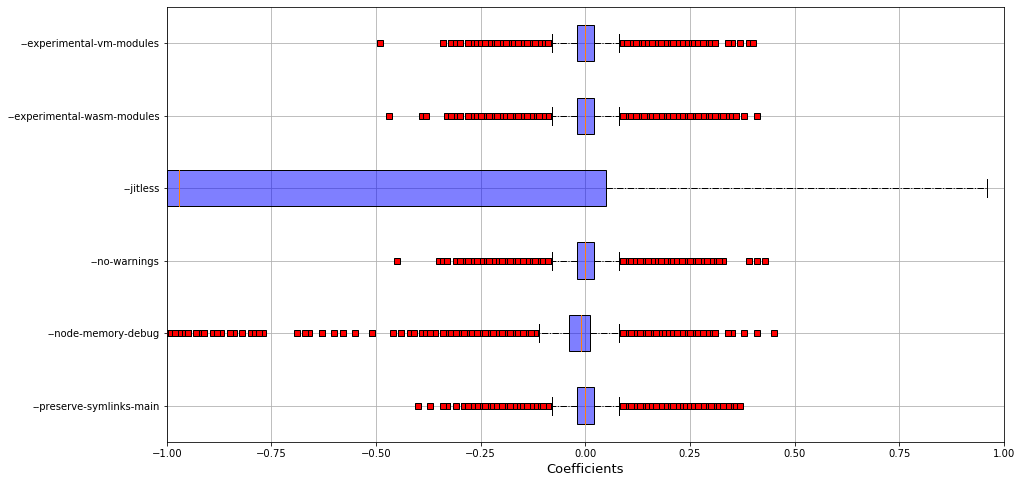

In [44]:
boxplot_imp("nodejs", "ops", xlim =[0,1], xname='Importances')
boxplot_imp("nodejs", "ops", xlim =[-1,1], xname='Coefficients')

For nodeJS, the `jitless` option is definitely the most influential across inputs.

In general, activating it will reduce the number of operations computed by the input (java)scripts. But there are few exceptions.

The other configuration option to watch is the `node-memory-debug` feature; for few inputs, it can have a greater influence than `jitless`.

### Poppler

#### size

RF
6.282863883270503e-05


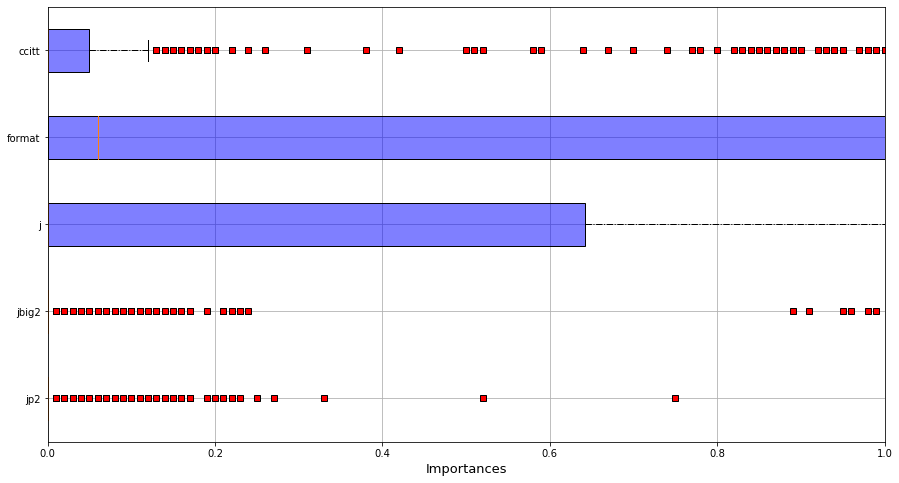

LR
0.002592395709397878


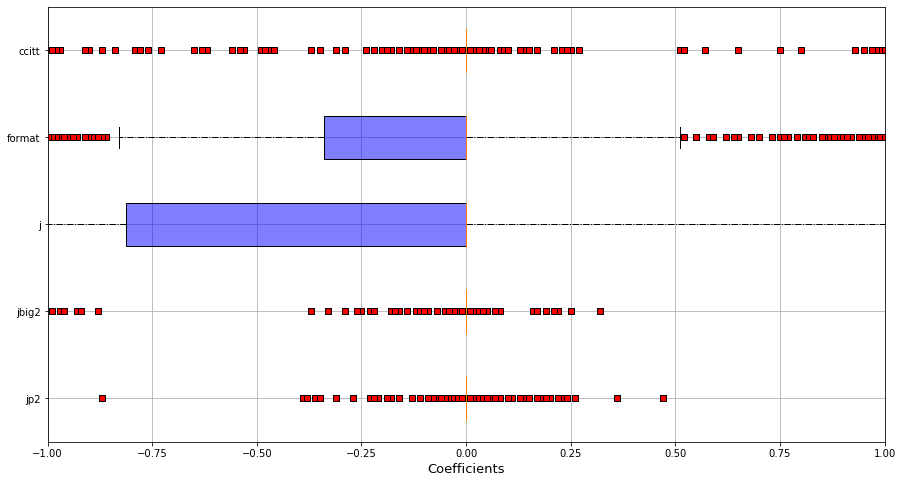

In [45]:
boxplot_imp("poppler", "size", xlim =[0,1], xname='Importances')
boxplot_imp("poppler", "size", xlim =[-1,1], xname='Coefficients')

The size of the output directory containing the images extracted from the pdfs is naturally highly dependent of the format of the output image (e.g. jpg, png, etc.).

But using a library to handle jpegs files can interact with the influential options for few inputs.

Again, this is a case where : (1) there is a general trend for the influential options but (2) for some inputs, it does not respect the rule.

It can be interesting to detect a priori the second cases (2) thanks to machine learning, so we can predict performances whatever the input. 

#### time

RF
0.027653318826777778


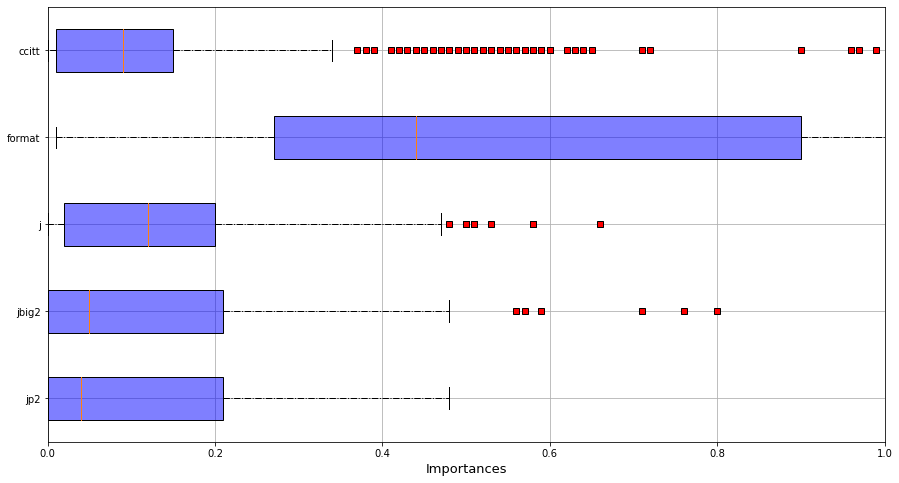

LR
1.6279265394301736


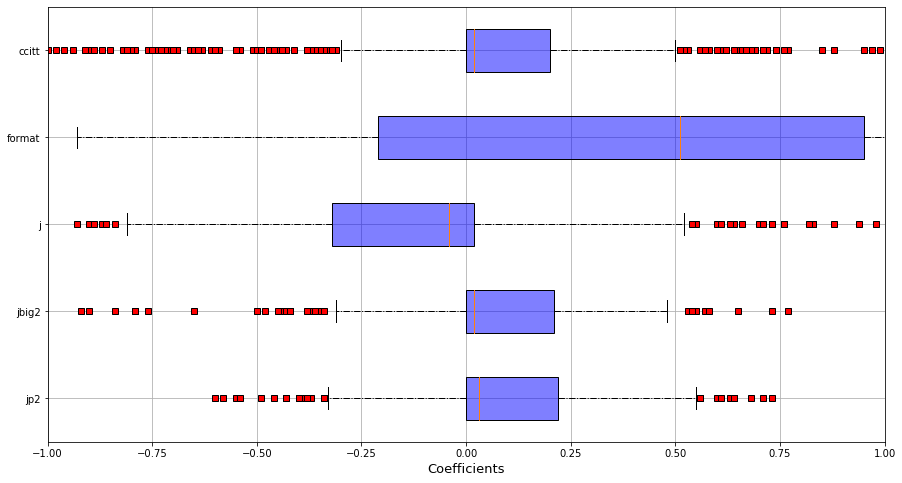

In [46]:
boxplot_imp("poppler", "time", xlim =[0,1], xname='Importances')
boxplot_imp("poppler", "time", xlim =[-1,1], xname='Coefficients')

Here, there is a compromise to find for the value of `format` between the time and the size, since activating `format` decreases the size, but increases the time.

And this value may depend on input data; we have to adapt the predictive model.

### SQLite

#### q1

RF
0.005763848888053999


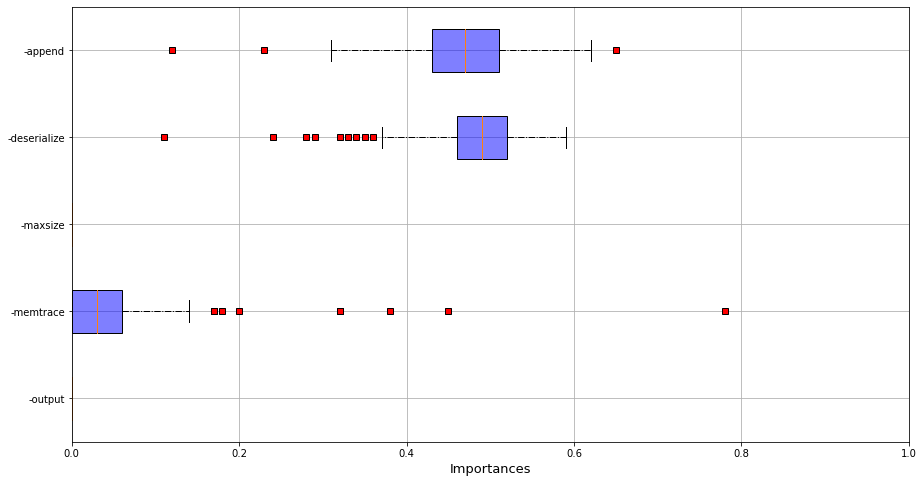

LR
4.571835627168448


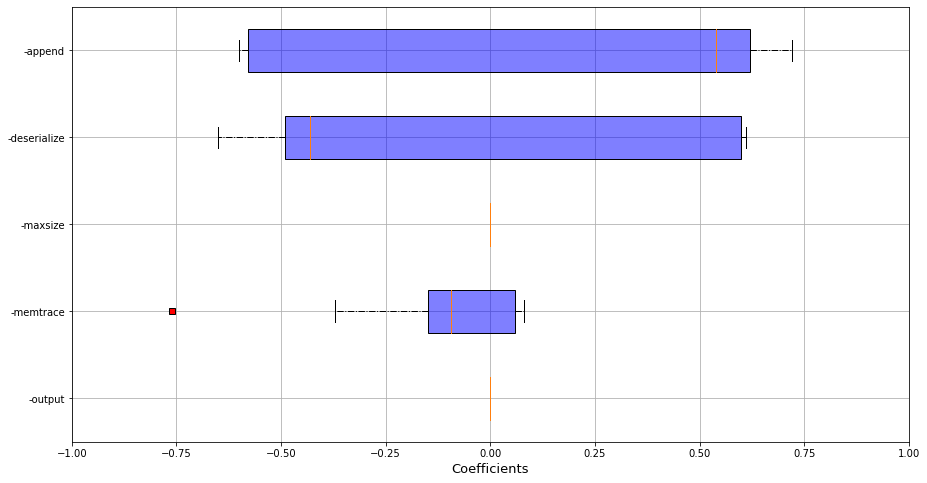

In [47]:
boxplot_imp("sqlite", "q1", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q1", xlim =[-1,1], xname='Coefficients')

#### q2

RF
0.03305197233460515


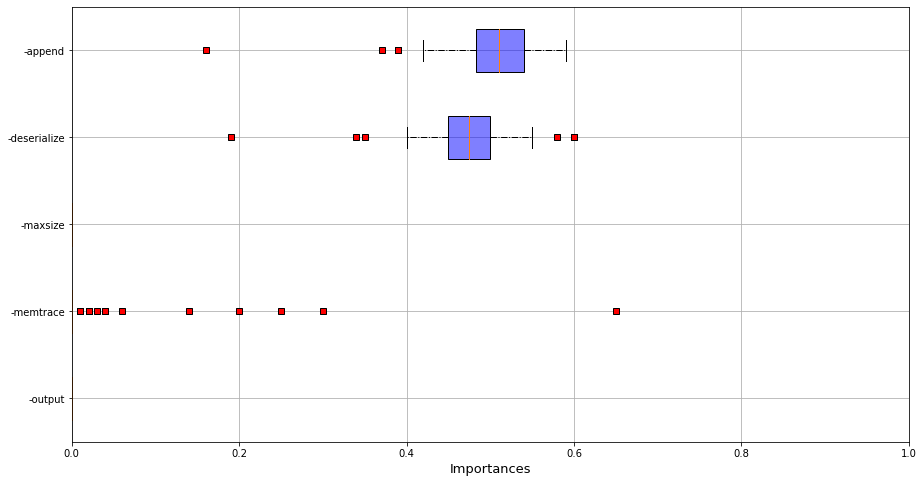

LR
3.1264439365181227


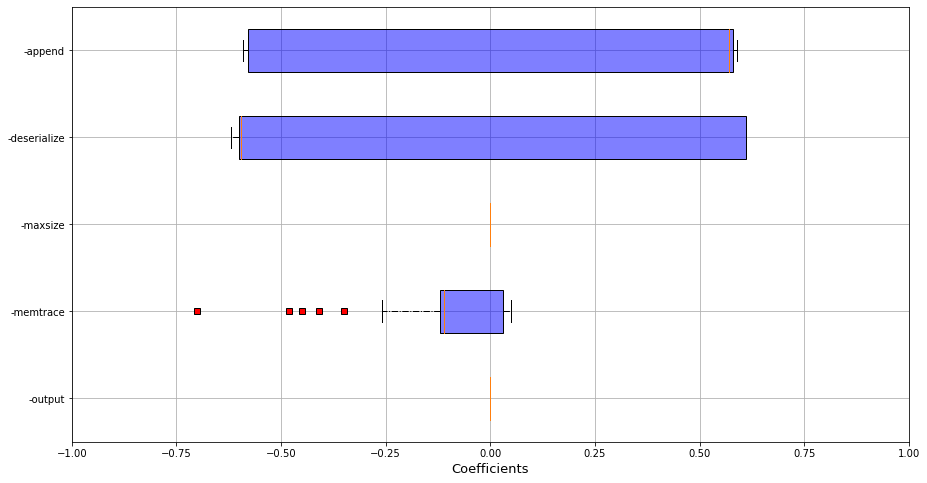

In [48]:
boxplot_imp("sqlite", "q2", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q2", xlim =[-1,1], xname='Coefficients')

#### q3

RF
0.008901968820397718


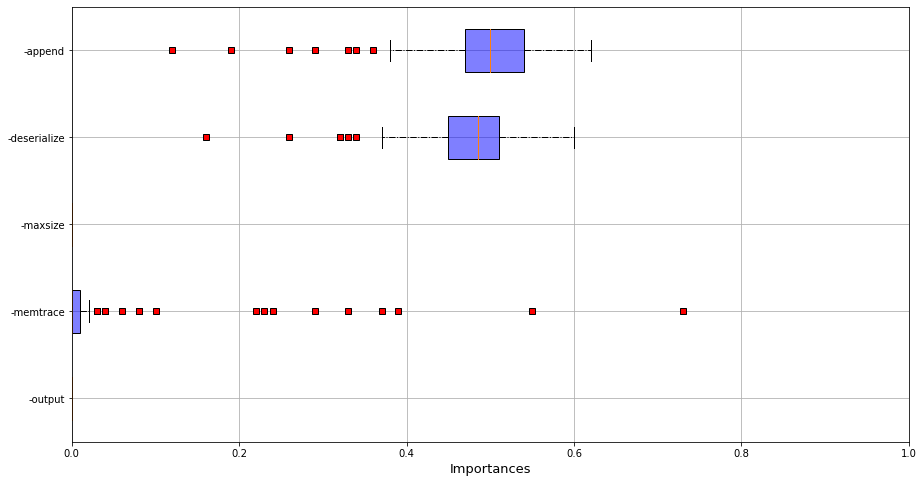

LR
3.6459056371586636


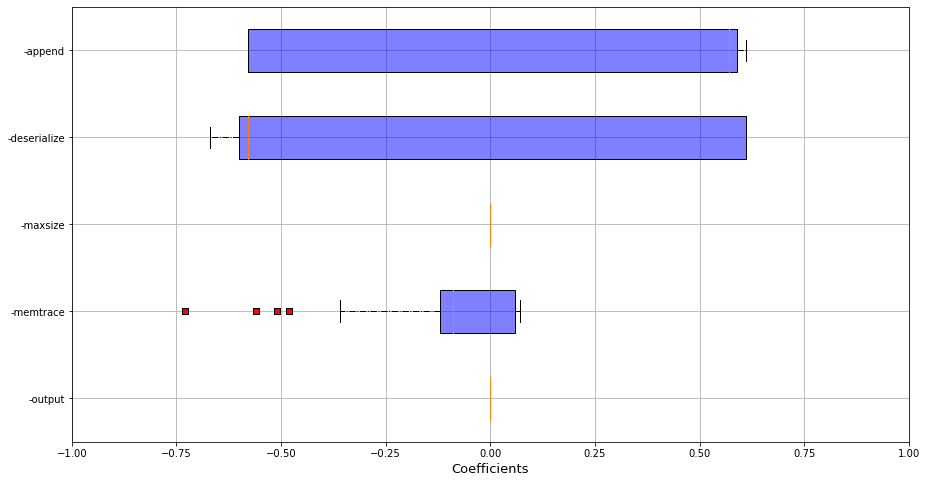

In [49]:
boxplot_imp("sqlite", "q3", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q3", xlim =[-1,1], xname='Coefficients')

#### q4

RF
0.016071103212252264


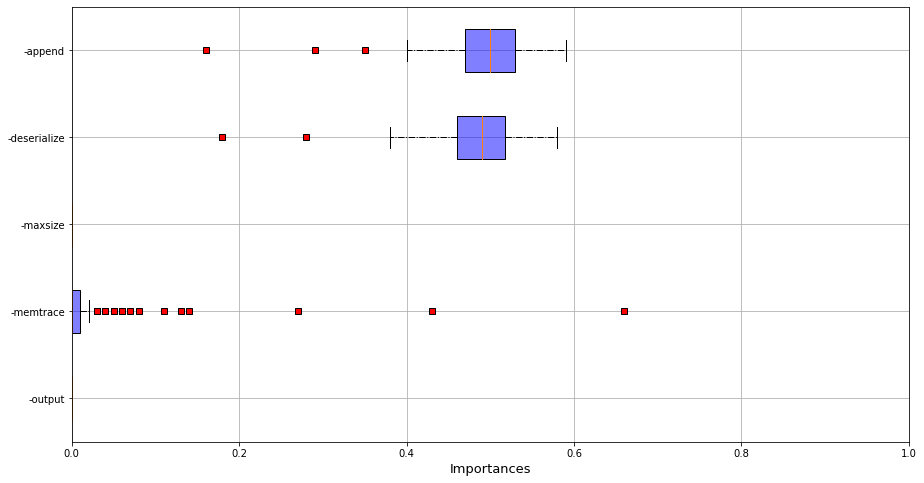

LR
3.8253617964909816


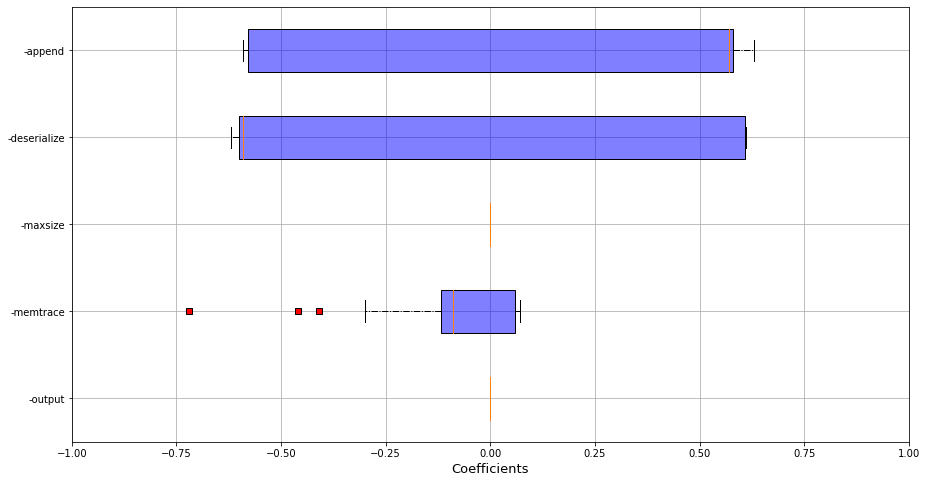

In [50]:
boxplot_imp("sqlite", "q4", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q4", xlim =[-1,1], xname='Coefficients')

#### q5

RF
0.006596547601962599


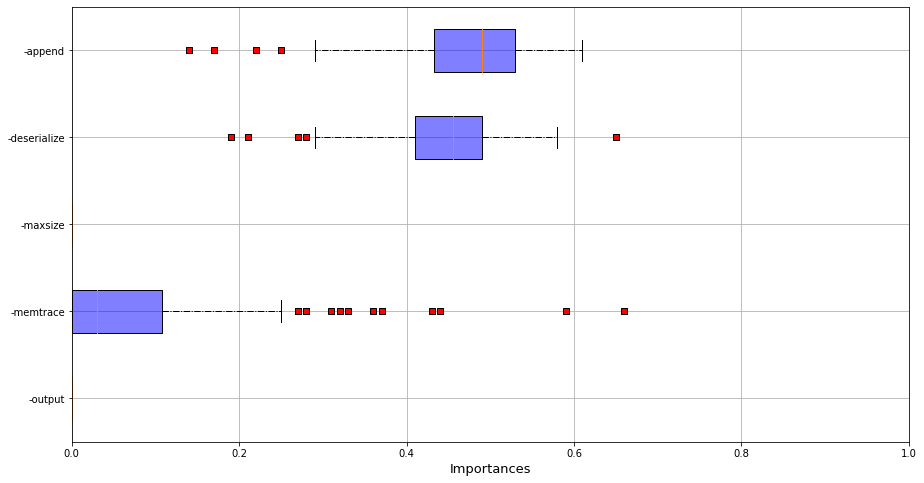

LR
5.503504984776908


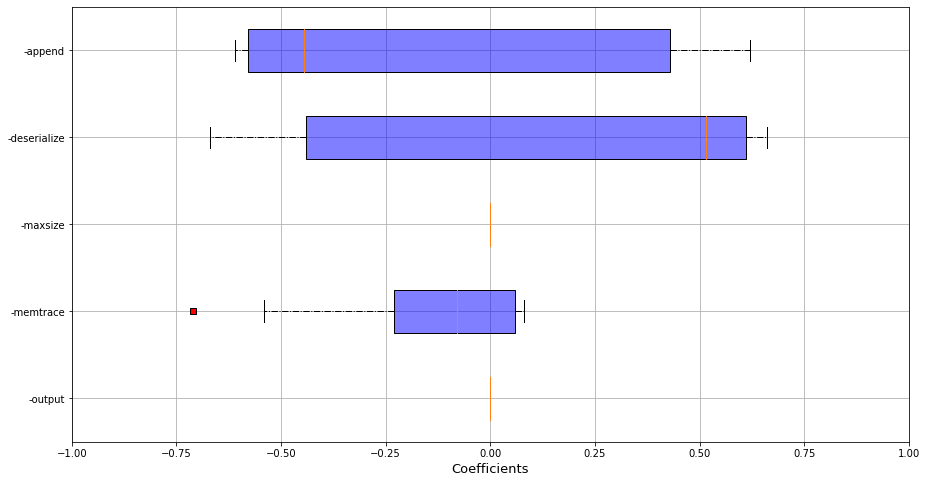

In [51]:
boxplot_imp("sqlite", "q5", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q5", xlim =[-1,1], xname='Coefficients')

#### q6

RF
0.011124193218999339


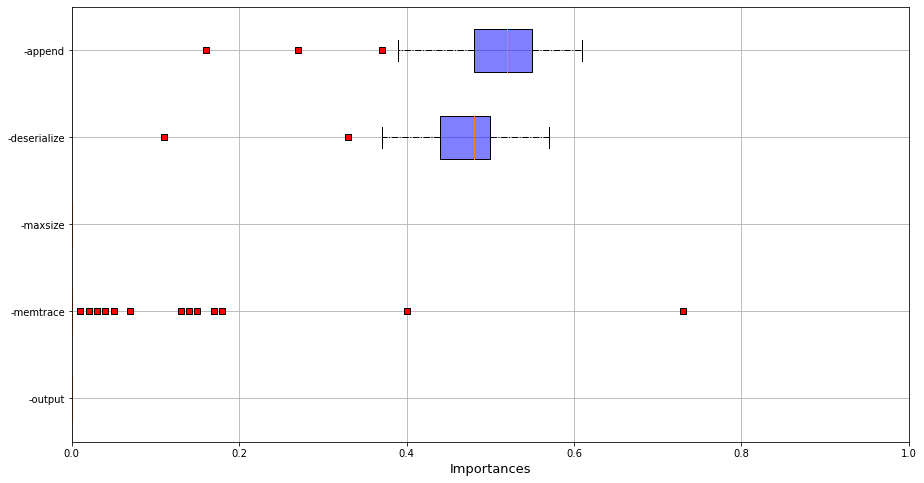

LR
4.250059644778015


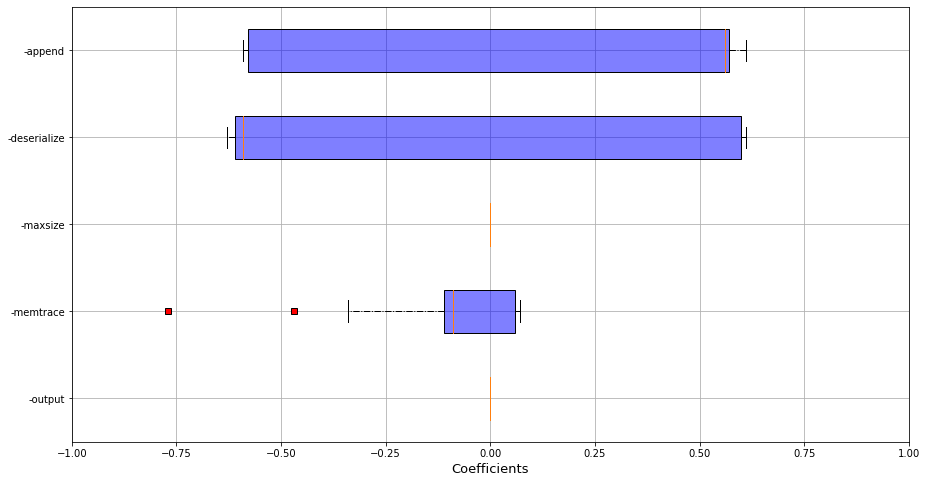

In [52]:
boxplot_imp("sqlite", "q6", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q6", xlim =[-1,1], xname='Coefficients')

#### q7

RF
0.004625412124265054


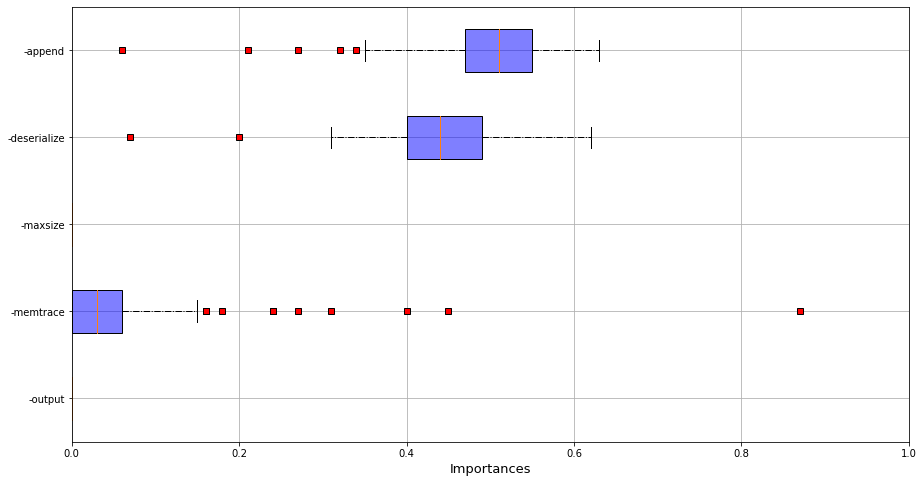

LR
3.733936584556587


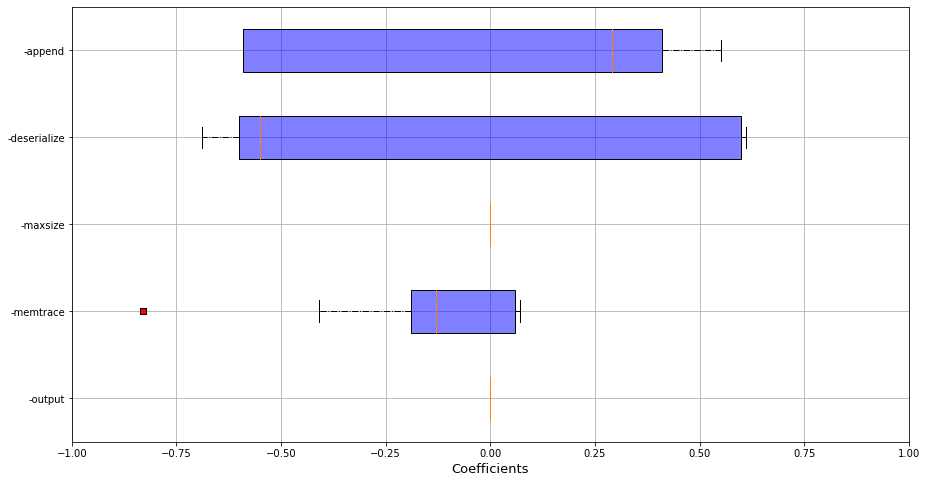

In [53]:
boxplot_imp("sqlite", "q7", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q7", xlim =[-1,1], xname='Coefficients')

#### q8

RF
0.010728344997748081


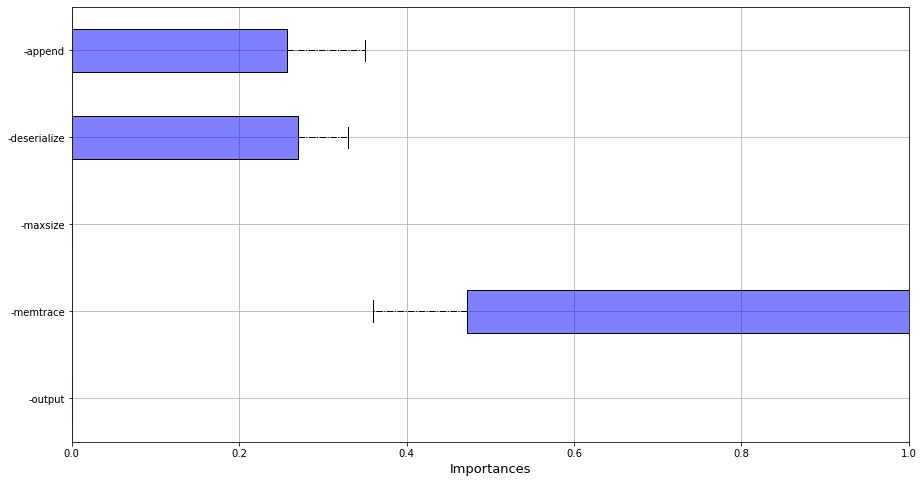

LR
0.033178963878773476


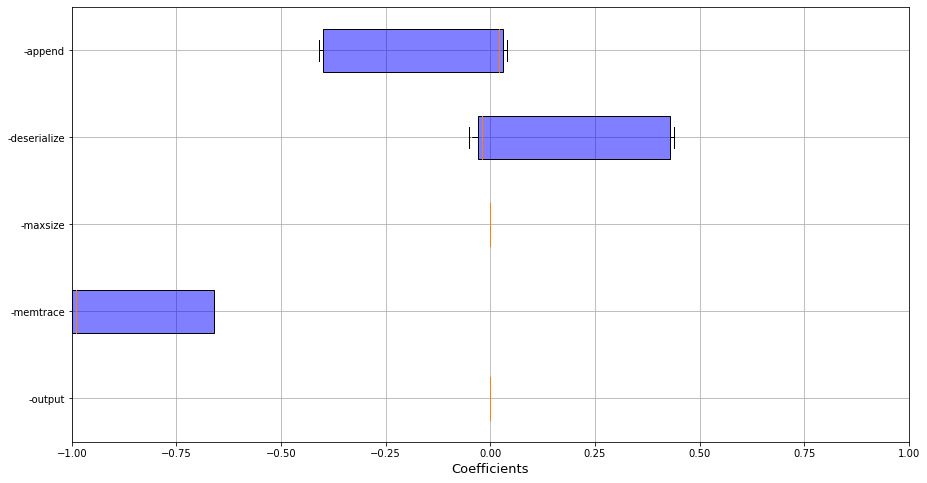

In [54]:
boxplot_imp("sqlite", "q8", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q8", xlim =[-1,1], xname='Coefficients')

#### q9

RF
0.00803516758773565


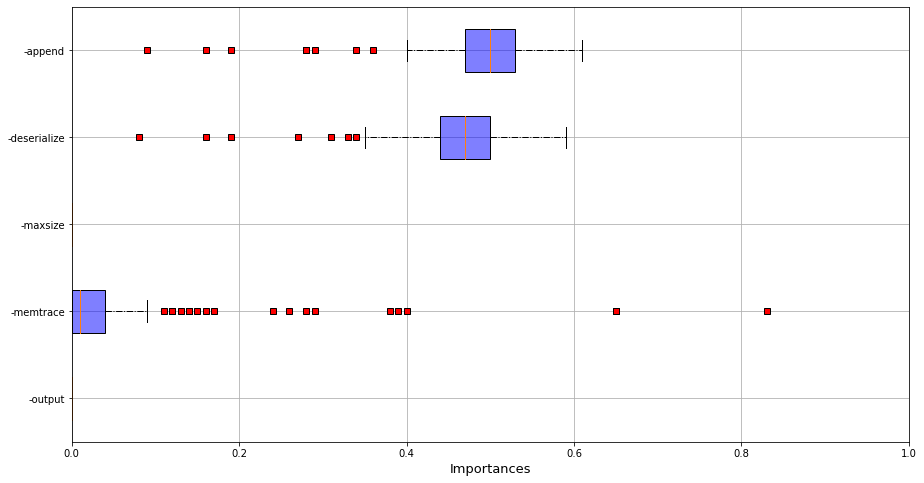

LR
2.1971037570073357


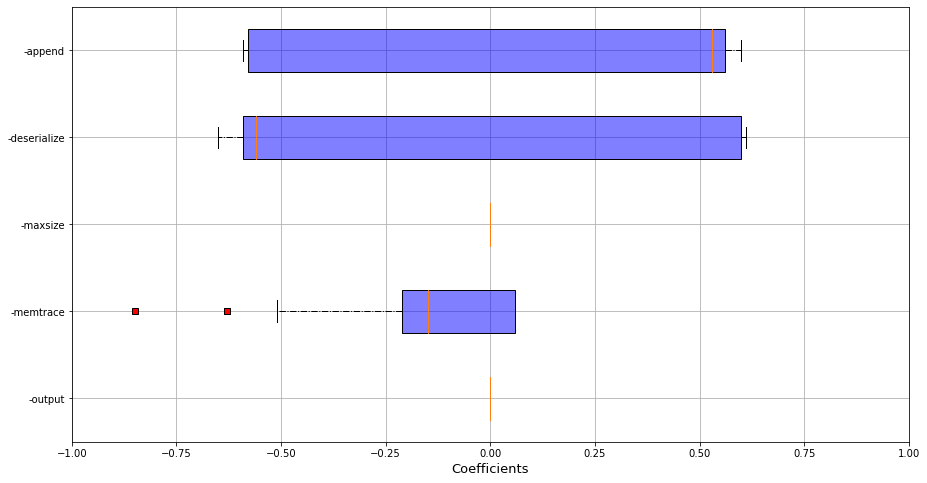

In [55]:
boxplot_imp("sqlite", "q9", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q9", xlim =[-1,1], xname='Coefficients')

#### q10

RF
0.008653437963748768


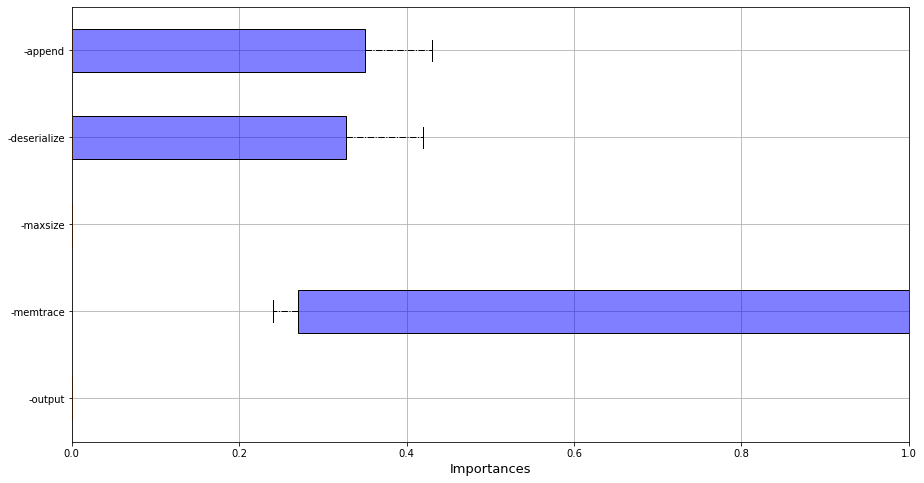

LR
0.03915515469706694


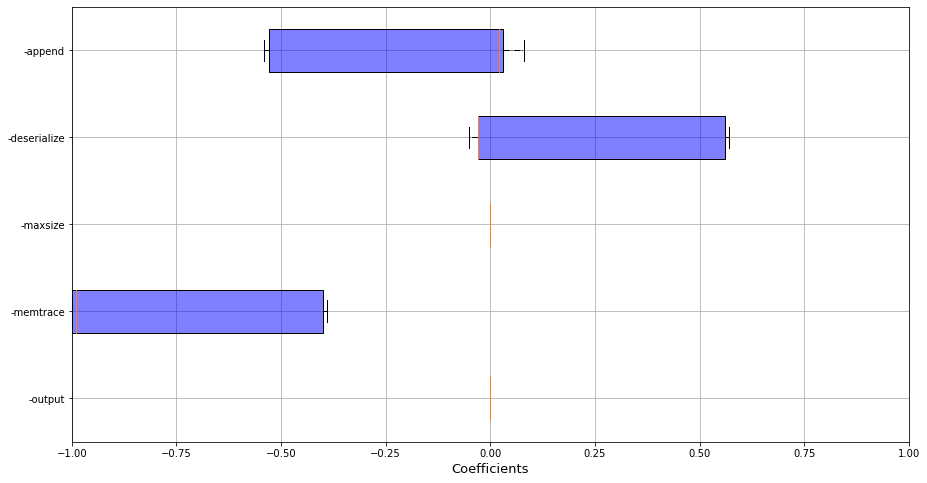

In [56]:
boxplot_imp("sqlite", "q10", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q10", xlim =[-1,1], xname='Coefficients')

#### q11

RF
0.017707272383159237


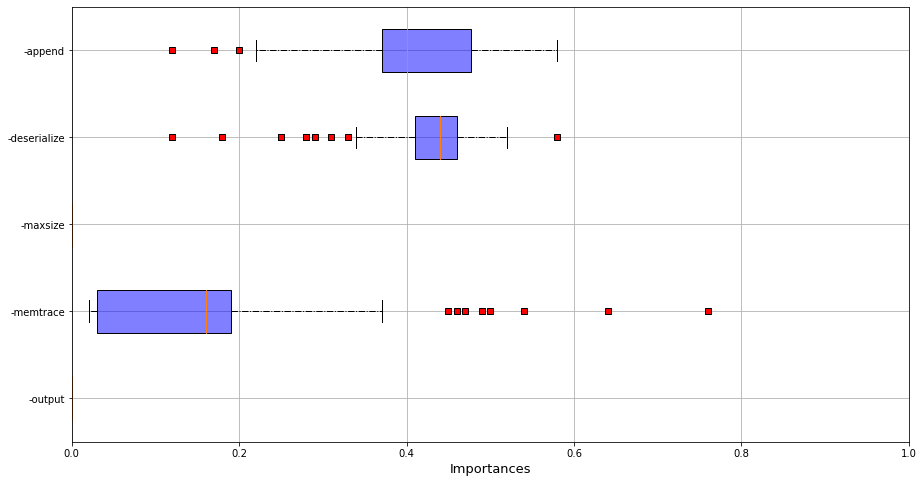

LR
0.8897985050451831


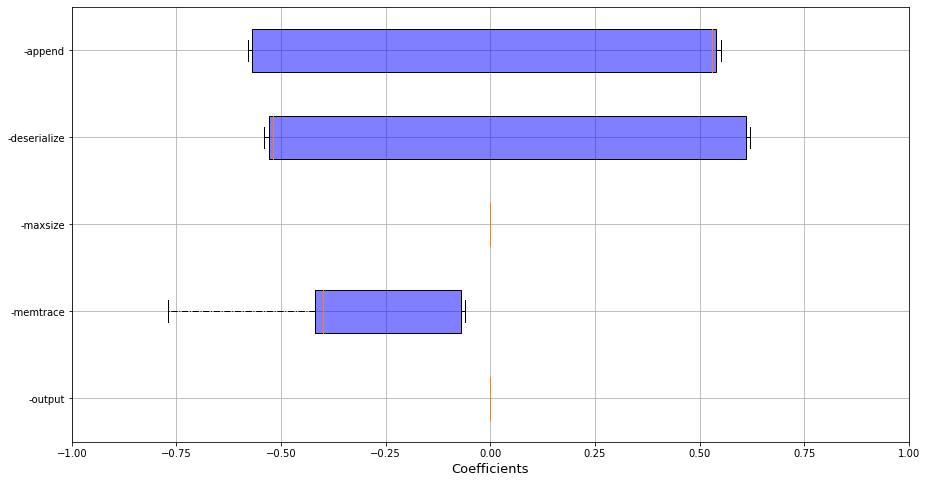

In [57]:
boxplot_imp("sqlite", "q11", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q11", xlim =[-1,1], xname='Coefficients')

#### q12

RF
0.011819427737343215


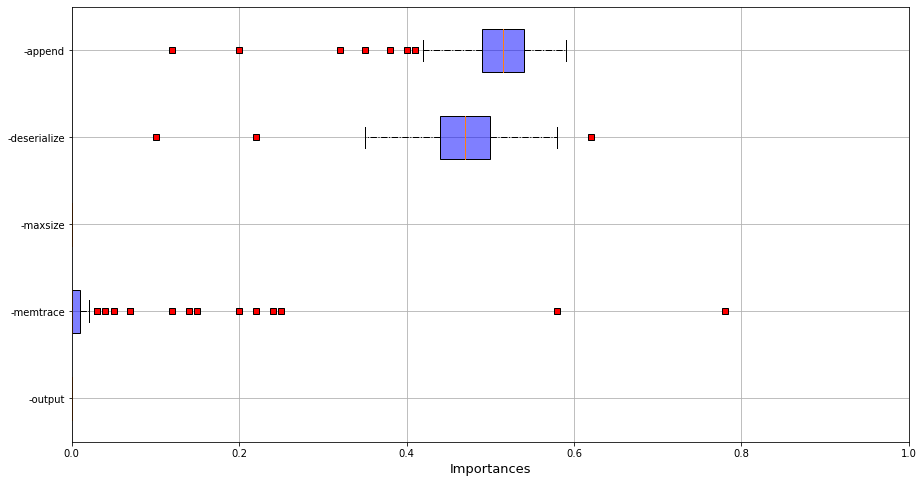

LR
3.9726374388106898


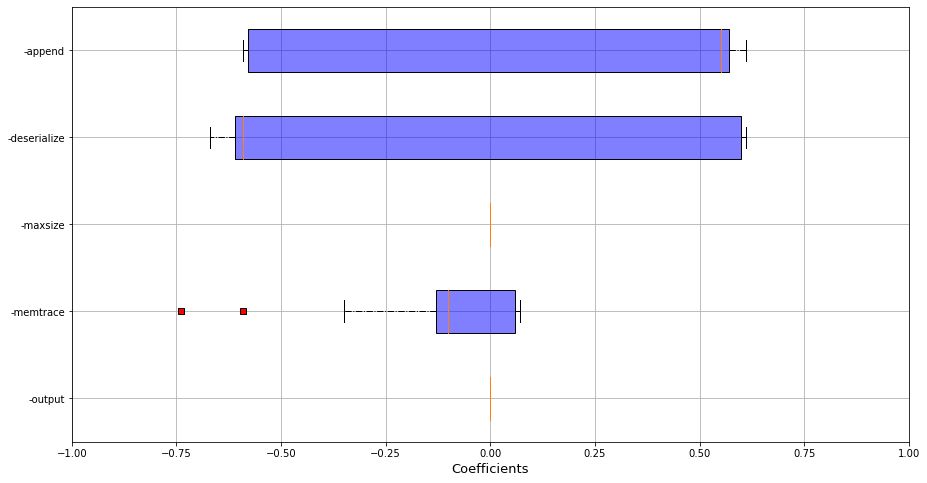

In [58]:
boxplot_imp("sqlite", "q12", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q12", xlim =[-1,1], xname='Coefficients')

#### q13

RF
0.018391985345292135


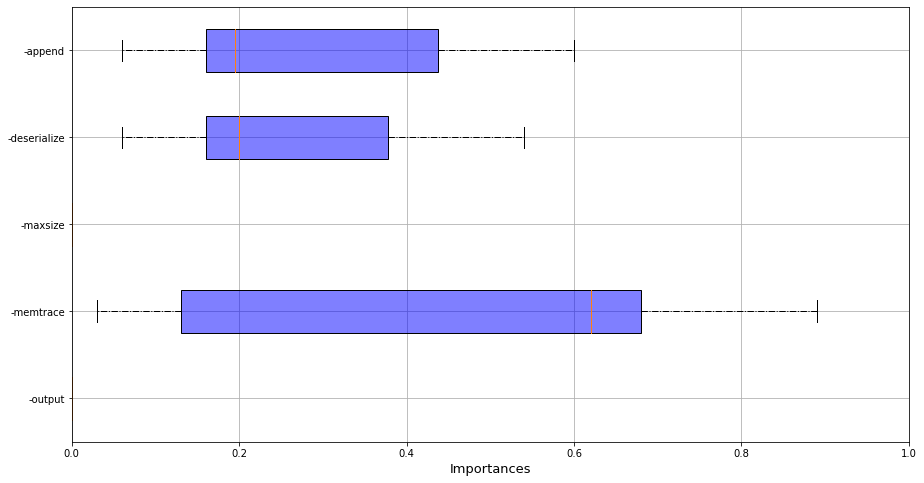

LR
1.8536170003481147


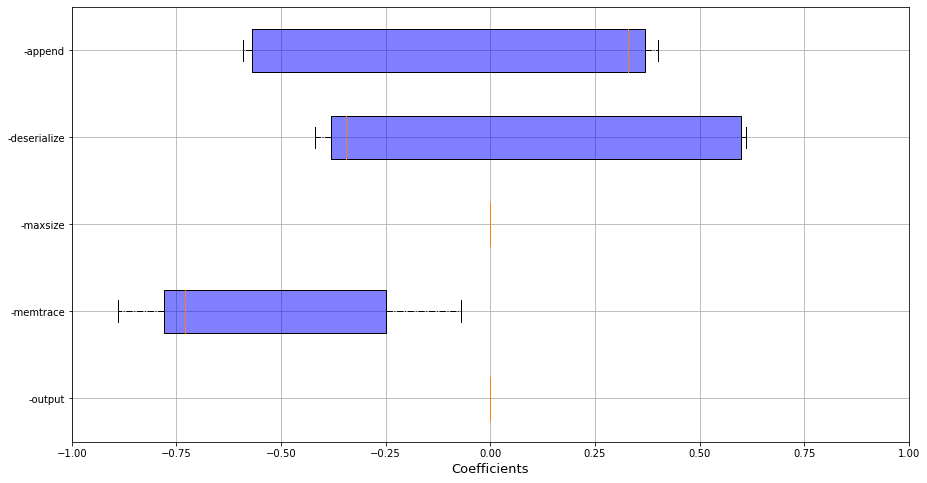

In [59]:
boxplot_imp("sqlite", "q13", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q13", xlim =[-1,1], xname='Coefficients')

#### q14

RF
0.010817672708329985


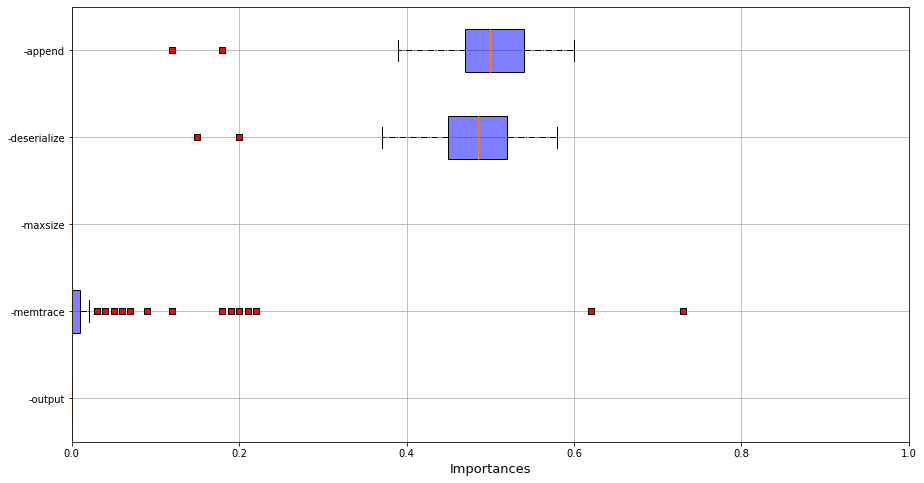

LR
3.4567069311598657


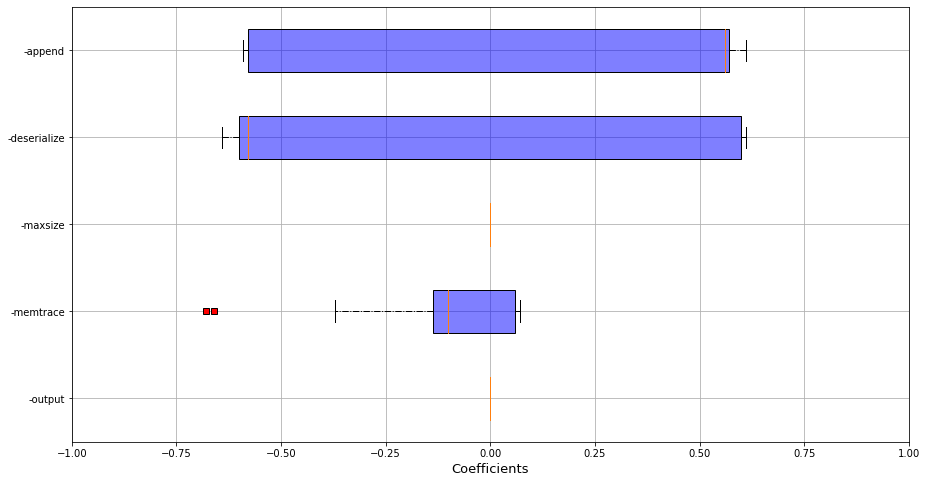

In [60]:
boxplot_imp("sqlite", "q14", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q14", xlim =[-1,1], xname='Coefficients')

#### q15

RF
0.01749145397938872


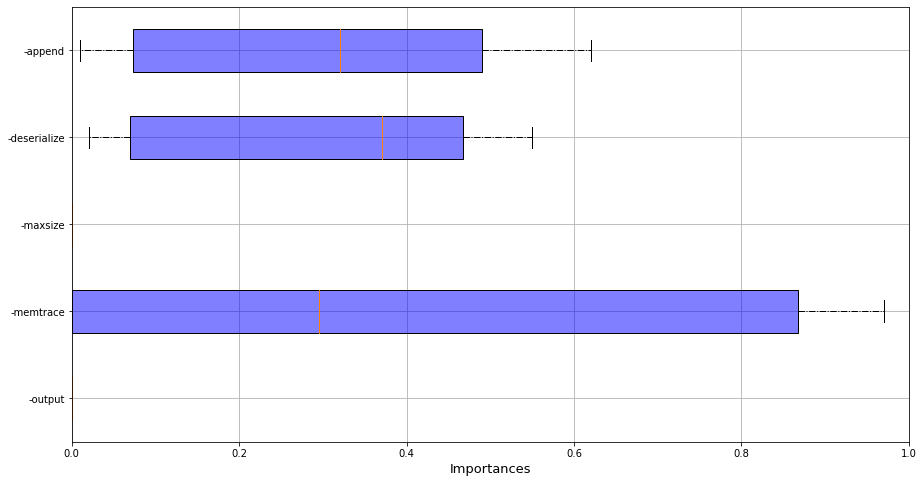

LR
1.5004381728359113


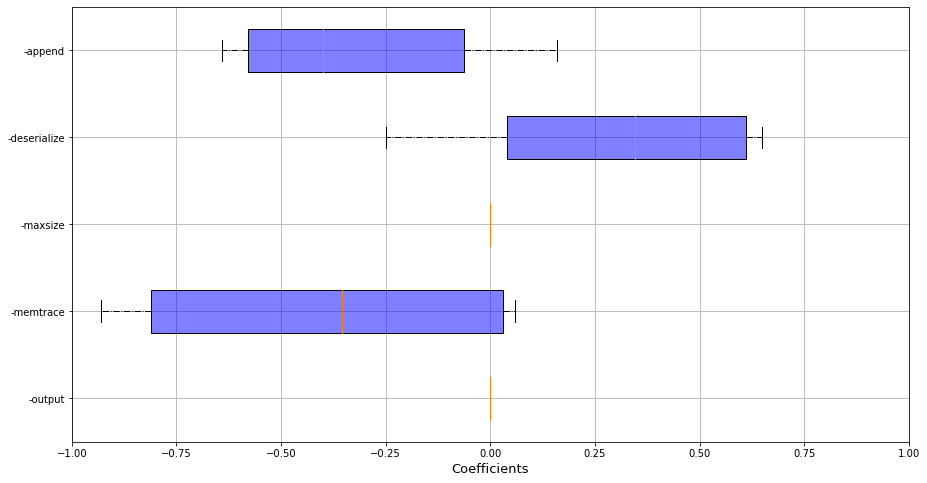

In [61]:
boxplot_imp("sqlite", "q15", xlim =[0,1], xname='Importances')
boxplot_imp("sqlite", "q15", xlim =[-1,1], xname='Coefficients')

Between the different queries, the importances of options and the effect of coefficients vary.

SQLite is an input-sensitive software system.

### xz

#### size

RF
1.1989824413697374e-05


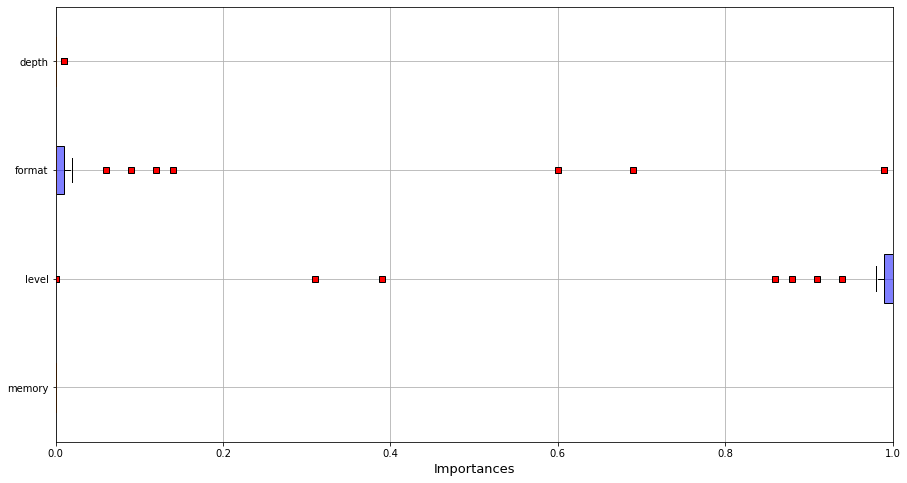

LR
1.4746377480607082


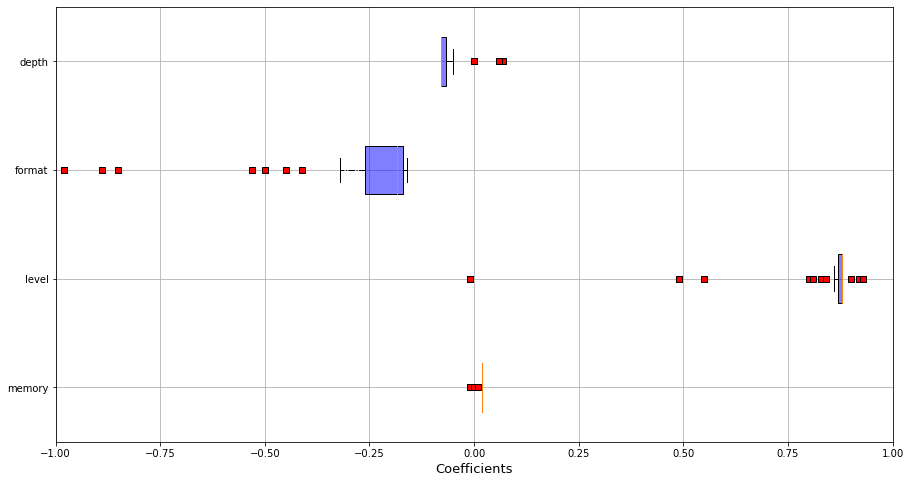

In [62]:
boxplot_imp("xz", "size", xlim =[0,1], xname='Importances')
boxplot_imp("xz", "size", xlim =[-1,1], xname='Coefficients')

Like gcc, another case of stability w.r.t. input sensitivity

The influential options remain the same, with the same effect.

#### time

RF
0.014301833787971611


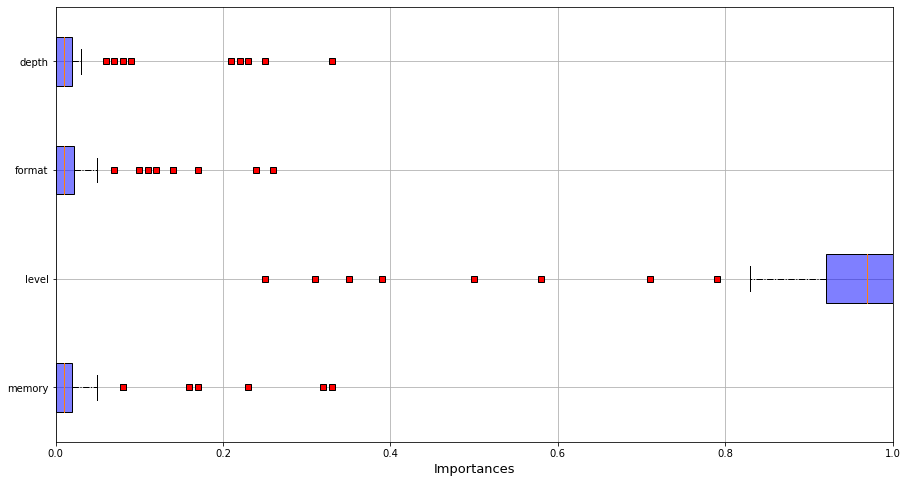

LR
1.1398114881111576


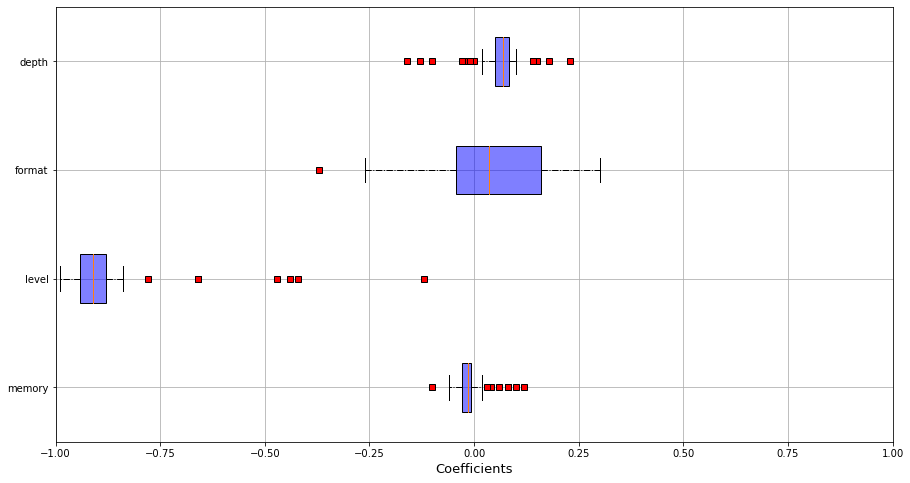

In [63]:
boxplot_imp("xz", "time", xlim =[0,1], xname='Importances')
boxplot_imp("xz", "time", xlim =[-1,1], xname='Coefficients')

Globally similar conclusion as for the size. 

The more stable the effect of options in RQ2, the more stable the distribution of performances in RQ1.

### x264

#### bitrate

RF
0.012418058273291083


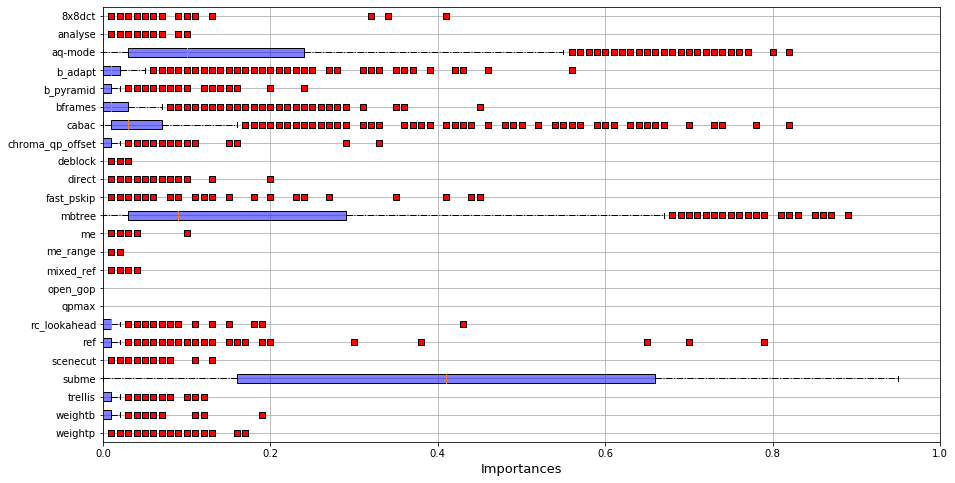

LR
1.4477338091852456


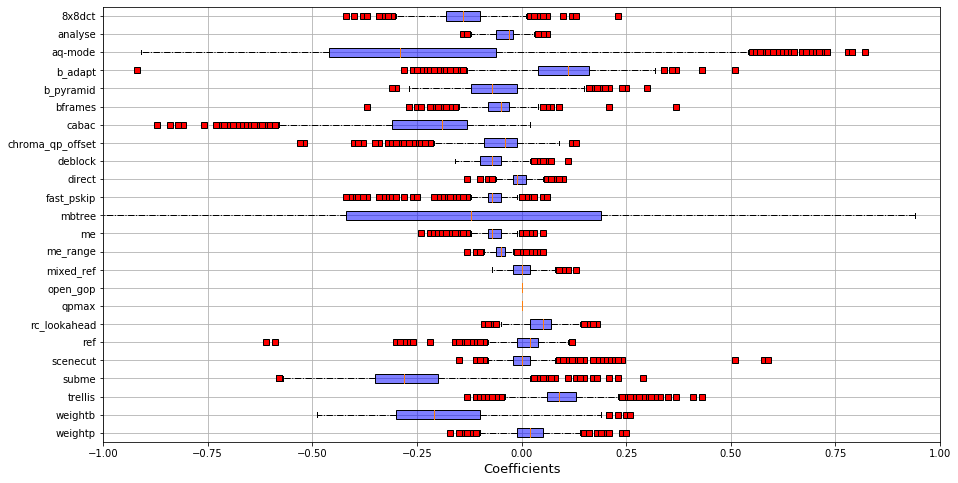

In [64]:
boxplot_imp("x264", "kbs", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "kbs", xlim =[-1,1], xname='Coefficients')

x264 can encode different kinds of videos, such as an animation movie with many details, or a soccer game with large and monochromatic areas of grass. 
When encoding the soccer game, x264 can use those fixed green areas to reduce the amount of data encoded per second i.e. the bitrate. 
In other words, configuration options aggregating pixels (e.g. macro-block tree estimation `mbtree`) could: reduce the bitrate for the soccer game; increase the bitrate for the animation movie since nothing can be aggregated. 


This figures report on respectively the boxplots of configuration options' importances and effects when predicting x264's bitrate for all input videos. 

Three options are strongly influential for a majority of videos: 
`subme`, `mbtree` and `aq-mode`, but their importance can differ depending on input videos: for instance, the importance of subme is 0.83 for video 1365 and only 0.01 for 40. 
Because influential features vary with input videos for x264, performance models and approaches based on *feature selection* may not generalize well to all input videos. 


Most of the options have positive and negative coefficients; thus, the specific effects of options heavily depend on input videos. 
It is also true for influential options: mbtree can have positive and negative (influential) effects on the bitrate i.e. activating mbtree may be worth only for few input videos. 
The consequence is that one cannot reliably provide end-users with a unique x264 performance prediction model or a x264 default configuration whatever the input is.


#### frame encoded per second

RF
0.051871369892231435


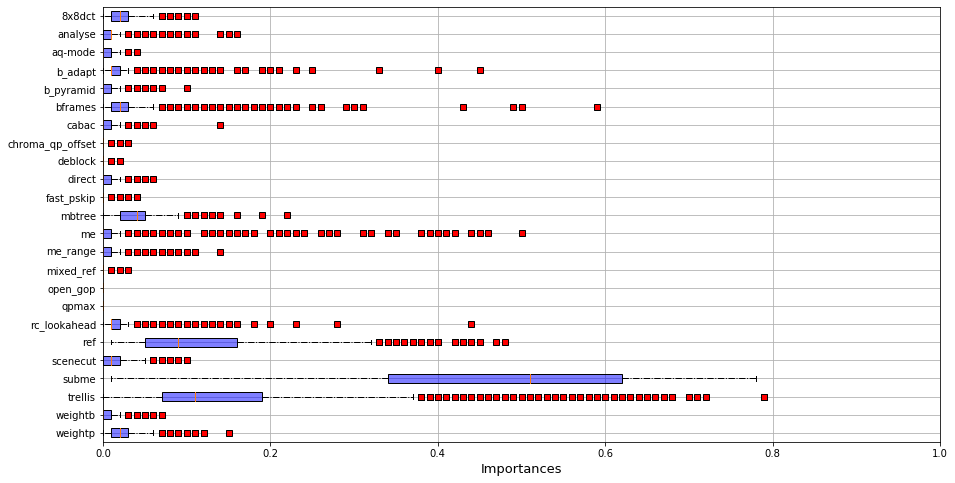

LR
1.4318709399497558


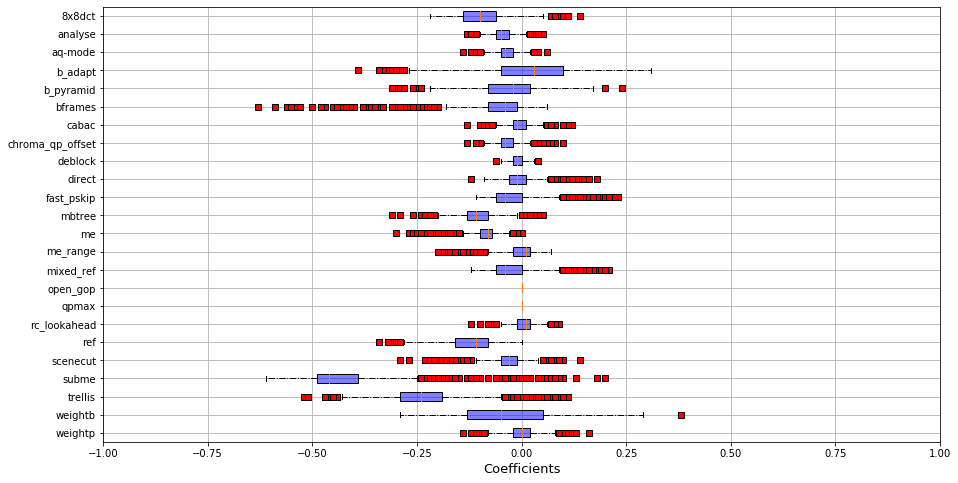

In [65]:
boxplot_imp("x264", "fps", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "fps", xlim =[-1,1], xname='Coefficients')

#### CPU usage

RF
0.028206993909083395


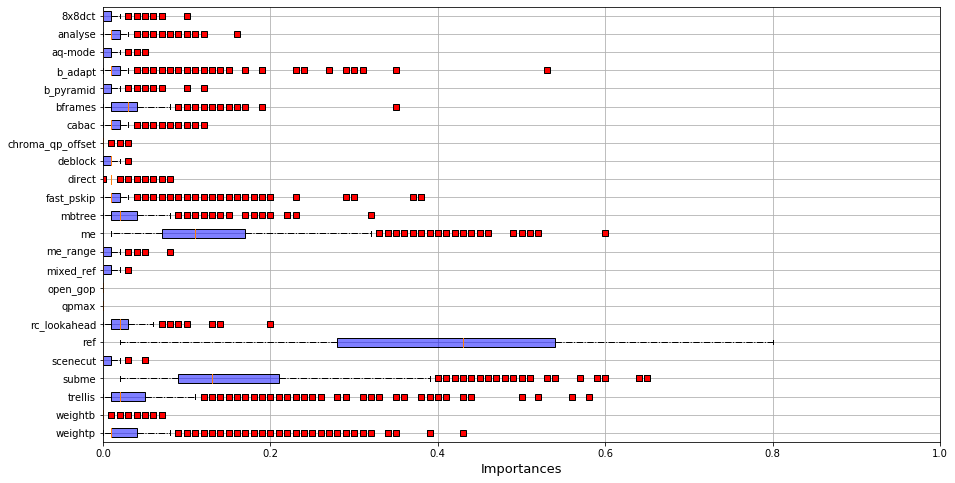

LR
1.7736425336819597


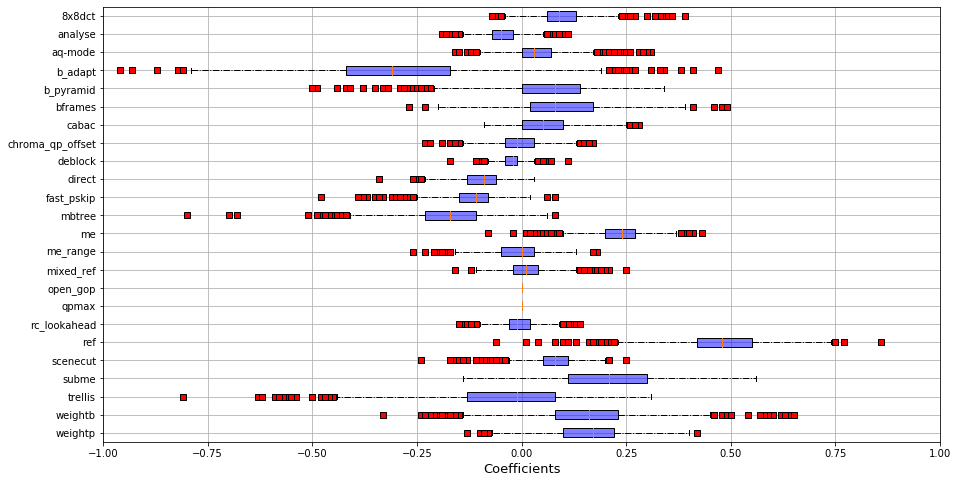

In [66]:
boxplot_imp("x264", "cpu", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "cpu", xlim =[-1,1], xname='Coefficients')

#### Encoded size of video

RF
0.01249929437579751


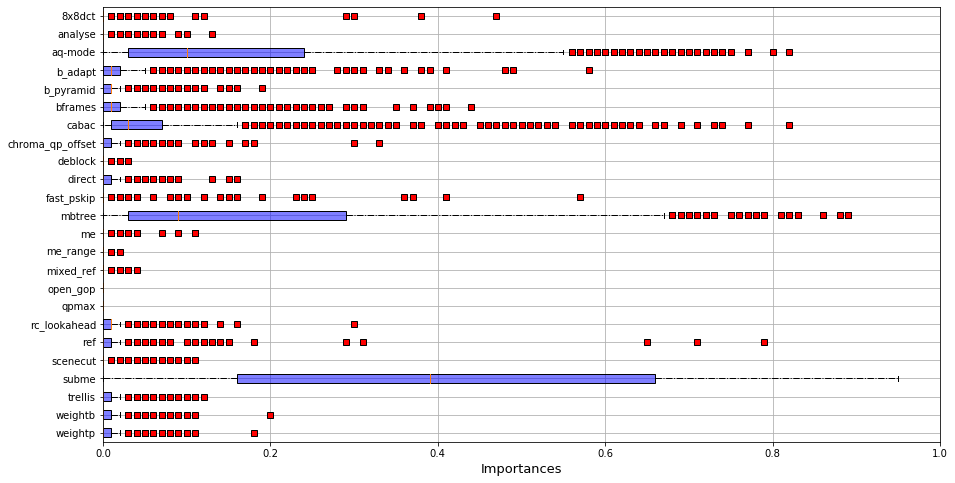

LR
1.4477404802875626


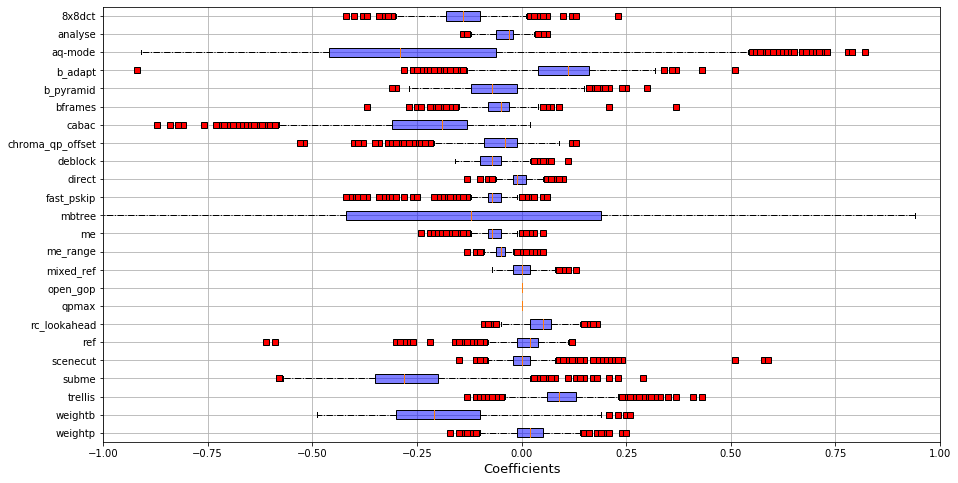

In [67]:
boxplot_imp("x264", "size", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "size", xlim =[-1,1], xname='Coefficients')

#### Encoding time

RF
0.0464149273660174


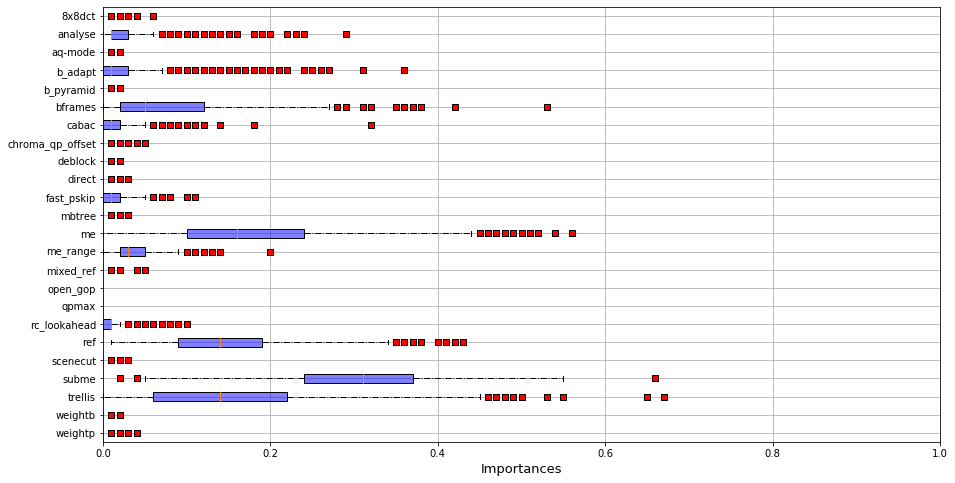

LR
2.020703824962156


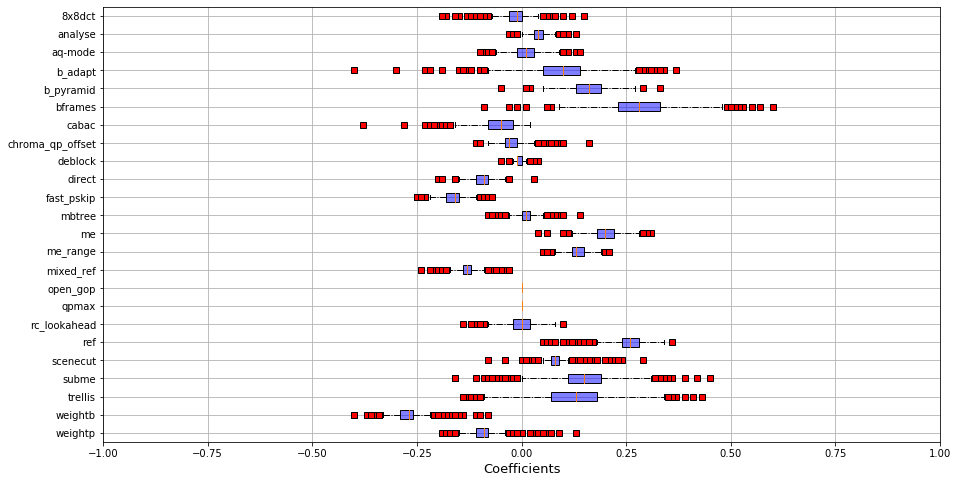

In [68]:
boxplot_imp("x264", "etime", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "etime", xlim =[-1,1], xname='Coefficients')